In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 
import difflib 


In [38]:
def MVA(years):
    col_name = ["COLLISION_DATE","COLLISION_TIME","PRIMARY_RD","SECONDARY_RD","CHP_BEAT_TYPE","WEATHER_1","COLLISION_SEVERITY","PRIMARY_COLL_FACTOR","PCF_VIOL_CATEGORY","LIGHTING","ROAD_SURFACE","ROAD_COND_1"]
    MVA_DF = pd.DataFrame(data=None, index=None, columns=col_name, dtype=None) #New empty dataframe
    MVA_DF_2015 = pd.DataFrame(data=None, index=None, columns=col_name, dtype=None) #New empty dataframe
    size=0
    for year in years:
        if (year != 2012) : 
            DF = pd.read_csv('CollisionRecords%i.txt' % year,sep = ',', dtype='unicode') #Read the csv file
            DF = DF[col_name]
            DF = cleaning_MVA(DF)
            size += len(DF) #Check size matches 
            if year >= 2015 : 
                MVA_DF_2015 = MVA_DF_2015.append(DF)#Add DF to our initialized dataframe
            else : 
                MVA_DF = MVA_DF.append(DF)#Add DF to our initialized dataframe

            
    print(size)#Just to check
    return(MVA_DF,MVA_DF_2015)

def OCI(year_oci):
    dct_oci = {2011: 'DF_OCI_2011', 2015: 'DF_OCI_2011'}
    for year in year_oci : 
        dct_oci[year] = pd.read_csv('OCI_SD_%i.csv' % year,sep = ',', dtype='unicode') #Read the csv file
        dct_oci[year]= dct_oci[year][['oci','street','street_from','street_to','oci_desc']] #Keep only relevant variables
    return(dct_oci)

In [ ]:
def cleaning_MVA(MVA_DF):
    print("original size : ", len(MVA_DF))
    MVA_DF= MVA_DF.reset_index(drop=True)
    reg = re.compile("((.*)?I(-|\s)?(-|\s)?\d+)(.*)?|(.*)?((S|R)(.)?(R|T)(.)?(\s)?\d+)(.*)?")
    count = 0
    pattern_digitAV = re.compile("^(^[0-9])([A-Z].*)") #If start with one digit and followed by str
    dico = {"HWY" : "HY", "RT " : "I-","INTERSTATE ": "I-","STATE ROUTE ": "I-","STREET": "ST","AVENUE":"AV","AVE":"AV","EAST": "E","WEST":"W","NORTH":"N","SOUTH":"S"} 
    for i in range(len(MVA_DF)) : #When finished, len(DF)
        (MVA_DF["PRIMARY_RD"])[i] = multiple_replace(dico,(MVA_DF["PRIMARY_RD"])[i]) #Get the street name
        (MVA_DF["SECONDARY_RD"])[i] = multiple_replace(dico,(MVA_DF["SECONDARY_RD"])[i]) #Get intersection 
        digit_AV_street = pattern_digitAV.match((MVA_DF["PRIMARY_RD"])[i]) # Check if match with pattern
        digit_AV_Inter =pattern_digitAV.match((MVA_DF["SECONDARY_RD"])[i]) # Check if match with pattern
        if digit_AV_Inter is not None : 
            (MVA_DF["SECONDARY_RD"])[i]= "0" + digit_AV_Inter.group()    #Add a 0 in front if match
        if digit_AV_street is not (None):
            (MVA_DF["PRIMARY_RD"])[i] = "0" + digit_AV_street.group() #Add a 0 in front if match
        if reg.match((MVA_DF["PRIMARY_RD"])[i]):
            MVA_DF.drop(i, inplace=True)
            count = count+1
    MVA_DF = MVA_DF.loc[MVA_DF.PCF_VIOL_CATEGORY != '1'] #If driving under drugs or alcohol
    print("count",count)
    print("lenDF: ",len(MVA_DF))
    return (MVA_DF)

def multiple_replace(dico, name_street):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dico.keys())))

  # For each match, look-up corresponding value in dictionary
  return (regex.sub(lambda mo: dico[mo.string[mo.start():mo.end()]], name_street) )


In [ ]:
def street_match(MVA_DF,DF_OCI):
    print('Je suis la')
    DF = pd.DataFrame(data=None, index=None, columns= None, dtype=None) #Will be final merged DF
    street_len = 0 #Var for number of Primary_RD not matching street name
    intersection_len = 0 #Var for number of Secondary_RD not matching street_from or street_to
    MVA_DF= MVA_DF.reset_index(drop=True)

    for i in range(len(MVA_DF)) : #Loop through all the DF with the Accidents/Collisison
        street_name = (MVA_DF["PRIMARY_RD"])[i] #Get street_name from Primary_RD
        intersection = (MVA_DF["SECONDARY_RD"])[i] #Get the Secondary_RD/Intersection 
        TEMP = DF_OCI.loc[(DF_OCI['street'].str.contains(street_name))] #Get all the street in the OCI that contains or is equal to street_name (from MVA_DF)    
        if TEMP.empty: #If nothing matchs
            street_len = street_len +1
            Close_Match_Street = (difflib.get_close_matches(street_name, (DF_OCI['street']),n=1)) #Function that finds the closest match - Chose to only take one out of the different matches
            if (Close_Match_Street != []) : #If there is a match
                TEMPA = DF_OCI.loc[DF_OCI['street'].str.contains(Close_Match_Street[0])] #Get all the street names from DF_OCI that contain or is equal to this new close match
                TEMP3,intersection_len= inter(TEMPA,intersection_len,intersection,i)
                if not TEMP3.empty : 
                    DF = dataframe(TEMP3,i,DF,MVA_DF)
            else :
                print("No street match")
                print("Street : ",street_name," Intersection : ",intersection)        
        else : 
            TEMP2,intersection_len= inter(TEMP,intersection_len,intersection,i) 
            DF= dataframe(TEMP2,i,DF,MVA_DF)

        print(i)
        
    return(DF)

In [ ]:

#Function to match the intersection (so Secondary_RD (from MVA DF) to either street_to or street_from the OCI DF )
def inter(TEMP,intersection_len,intersection,i) : 
    TEMP2 = pd.DataFrame(data=None, index=None, columns= None, dtype=None) #New empty dataframe    
    TEMP2 = TEMP.loc[(TEMP['street_from'] == intersection)|(TEMP['street_to']==(intersection))]   #If perfect match to one of them
    if TEMP2.empty : #If no perfect match
        Close_Match_Intersection = (difflib.get_close_matches(intersection, (TEMP['street_from']),n=1)) #Closest match in street_from
        Close_Match_To = (difflib.get_close_matches(intersection, (TEMP['street_to']),n=1)) #closest match in street_to
        if (Close_Match_Intersection != []) & (Close_Match_To != []) : #If both matched
            TEMP2 = TEMP.loc[(TEMP['street_from'] == Close_Match_Intersection[0])|(TEMP['street_to']== Close_Match_To[0])] #Take all the rows where it close matched
        elif (Close_Match_Intersection != []) : 
            TEMP2 = TEMP.loc[(TEMP['street_from'] == Close_Match_Intersection[0])] #If only street_from matched
        elif (Close_Match_To != []) : 
            TEMP2 = TEMP.loc[(TEMP['street_to'] == Close_Match_To[0])] #If only steet_to matched
        else : #No match
            #print("Street : ",street_name," Intersection : ",intersection,"INDEX : ",i)
            intersection_len = intersection_len +1 #Just to have an idea of how many intersections didnt match
    if TEMP2 is not None : 
        return(TEMP2,intersection_len)
    
def dataframe(TEMP,i,DF,MVA_DF): #Function to join the DF of the match and the OCI variables/columns of the corresponding match
    TEST = pd.DataFrame(data=None, index=None, columns= None, dtype=None)
    TEMP = TEMP.reset_index(drop=True)#From OCI DF
    TEMP1 = MVA_DF.loc[MVA_DF.index == i] #Get the right full row
    TEMP1 = TEMP1.reset_index(drop=True)#Reset index to not have any issues later on
    a = True 
    length = len(TEMP)
    if length ==1 : #If there was only one row that matched in the OCI DF then perfect !
        TEST = TEMP.join(TEMP1) #Join OCI corresponding row and MVA corresponding row
        DF = DF.append(TEST) #Append that to our final DF
    elif length > 1 : #If there is more than one match
        for j in range(len(TEMP)-1) :
            if (TEMP['oci_desc'])[j] != (TEMP['oci_desc'])[j+1]: #If the oci_desc doesnt match in all the rows that match
                a = False #Indicate that we are not appending it in our final DF - Choice from us - Could have done it very differently (like the mean of the oci from these rows but was afraid it would biais our data set)
        if a == True : #Only if no missmatch in oci_desc - Append it to final DF
            TEMP = TEMP.loc[[0]]
            TEST = TEMP.join(TEMP1)
            DF = DF.append(TEST)
    if DF is not None :
        return(DF)

In [ ]:
def save(DF,name) : #Since it takes a huge amount of time to run, once it's done, we save it as a csv file to work on it independently
    DF= DF.reset_index(drop=True)#Reset index
    DF.to_csv('%s.csv' % name)#Save it with the given name the function takes in input

In [ ]:
if __name__ == '__main__': #Thats what we actually run, it will call all the functions
    years = [2011,2013,2014,2015] #Could have asked the user to enter the wanted years but can just modify the list - 
    #NOTE : 2012 DF has an issue so that it why we are not taking it - 
    #For now only have from 2011 to 2015 but it will work if we want to add the 2016 or more one - Will automatically match it with the 2015 OCI DF for the years 2015 and above
    #The years below 2015 will match to the 2011 OCI we have
    MVA_1,MVA_2 = MVA(years) #Loads the data - seperate the years before and after 2015
    OCI_1 = OCI([2011,2015]) #Dictionnary with 2011 and 2015 oci loaded
    DF_1 = street_match(MVA_1,OCI_1[2011]) #Match years before 2015 with the 2011 OCI --> This is our final DF
    DF_2= street_match(MVA_2,OCI_1[2015])#Match years 2015 and above with 2015 OCI --> Second final DF (for comparison)
    save(DF_1,'DF_1') #Save it as DF_1
    save(DF_2,'DF_2') #Save it as DF_2
    

In [2]:
def transform(DF) : 
#LIGHT = DF['LIGHTING'].loc[(DF.LIGHTING == 'A')| (DF.LIGHTING == 'B')]
    DF['LIGHTING'].loc[(DF.LIGHTING == 'A')| (DF.LIGHTING == 'B')] = np.random.randint(70,100, len(DF['LIGHTING'].loc[(DF.LIGHTING == 'A')| (DF.LIGHTING == 'B')]))
    DF['LIGHTING'].loc[(DF.LIGHTING == 'E')| (DF.LIGHTING == 'D')] = np.random.randint(0,40, len(DF['LIGHTING'].loc[(DF.LIGHTING == 'E')| (DF.LIGHTING == 'D')]))
    DF['LIGHTING'].loc[(DF.LIGHTING == 'C')] = np.random.randint(40,70, len(DF['LIGHTING'].loc[(DF.LIGHTING == 'C')]))

    DF['WEATHER_1'].loc[(DF.WEATHER_1 == 'B')| (DF.WEATHER_1 == 'A')] = np.random.randint(70,100, len(DF['WEATHER_1'].loc[(DF.WEATHER_1 == 'A')| (DF.WEATHER_1 == 'B')]))
    DF['WEATHER_1'].loc[(DF.WEATHER_1 == 'G')] = np.random.randint(40,70, len(DF['WEATHER_1'].loc[(DF.WEATHER_1 == 'G')]))
    DF['WEATHER_1'].loc[(DF.WEATHER_1 == 'E')| (DF.WEATHER_1 == 'C')] = np.random.randint(0,40, len(DF['WEATHER_1'].loc[(DF.WEATHER_1 == 'C')| (DF.WEATHER_1 == 'E')]))
    return (DF)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 
#DF = pd.read_csv('DF_1.csv',sep = ',', dtype='unicode',index_col=0) #Read the csv file


In [4]:
DF_1 = pd.read_csv('DF_1.csv',sep = ',', dtype='unicode',index_col=0) #Read the csv file
DF_2 = pd.read_csv('DF_2.csv',sep = ',', dtype='unicode',index_col=0) #Read the csv file
DF_1 = transform(DF_1)
DF_2 = transform(DF_2)

In [5]:
LL = pd.read_csv('LL.csv',sep = ',', dtype='unicode',index_col=0)#0 to 615
LL2 =pd.read_csv('LL2.csv',sep = ',', dtype='unicode',index_col=0)#630 to 2000
LL3= pd.read_csv('LL3.csv',sep = ',', dtype='unicode',index_col=0)#2000 to 4000
LL4= pd.read_csv('LL4.csv',sep = ',', dtype='unicode',index_col=0)#4000 to end
LL5= pd.read_csv('LL5.csv',sep = ',', dtype='unicode',index_col=0)#615 to 630 

A = LL5.append(LL2.append(LL3.append(LL4)))
L1 = LL.loc[LL.LAT !='1.0']
TEMP_LL = DF_1[:len(L1)].join(L1)

In [6]:
TEMP_DF = DF_1.loc[DF_1.index >=615]
TEMP_LL2 = TEMP_DF.reset_index(drop=True)[:len(A)].join(A.reset_index(drop=True))

In [7]:
Final_LL = TEMP_LL.append(TEMP_LL2).reset_index(drop=True)
Final_LL['LAT'] = pd.to_numeric(Final_LL['LAT'],downcast='float')
Final_LL['LONG']=(pd.to_numeric(Final_LL['LONG'],downcast='float'))
Final_LL['oci']=(pd.to_numeric(Final_LL['oci'],downcast='float'))
len(Final_LL)

6359

In [7]:
import shapefile

# read the in the shapefile and list the methods associated with the object
sf = shapefile.Reader("ZillowNeighborhoods-CA.shp")
#dir(sf)
sfdbf = shapefile.Reader("ZillowNeighborhoods-CA.dbf")
metadata = sfdbf.shapeRecords()

In [8]:
def marker(name,pos,liste,color):
    #print(color)
    kw = dict(fill_color=color, radius=4)
    name = folium.CircleMarker(pos, **kw)
    liste.append(name)
    return (liste)

In [11]:
import pandas as pd
import folium
#PB : westlimit=-117.262754; southlimit=32.778778; eastlimit=-117.209155; northlimit=32.823234
#GASLAMP : westlimit=-117.165607; southlimit=32.706695; eastlimit=-117.159224; northlimit=32.71568

PBW=-117.262754; PBS=32.778778; PBE=-117.209155; PBN=32.823234 #Pacific Beach delimitations
GW=-117.165607; GS=32.706695; GE=-117.159224; GN=32.71568 #Gaslamp delimitations
LFair= Final_LL.loc[Final_LL.oci_desc == 'Fair'] 
LPoor= Final_LL.loc[Final_LL.oci_desc == 'Poor']
LGood= Final_LL.loc[Final_LL.oci_desc == 'Good']
lat = 32.8811
lon = -117.2375
L = [LPoor,LFair,LGood]
liste= []
a = 0
dic_color = {0:'red',1:'blue',2: 'green'} #Red for poor, blue for fair, green for good
for FPG in L : #So starts with LPoor, then LFair, then LGood
    print(a) #Just to know where we are at
    for i in FPG.index : 
        name = 'pos' + str(i)
        pos = [Final_LL.LAT[i], Final_LL.LONG[i]] #Get the lat/long of our row
        if (GS < float(Final_LL.LAT[i]) < GN) & (GW < float(Final_LL.LONG[i]) < GE) : #If it is Gaslamp area
            print('GASLAMP AREA',pos)
            liste= marker(name,pos,liste,dic_color[a]) #Add it to the list of points to draw on map with corresponding colors
        if (PBS < float(Final_LL.LAT[i]) < PBN) & (PBW < float(Final_LL.LONG[i]) <PBE ): #If it is in PB
            print('PB',pos)
            liste= marker(name,pos,liste,dic_color[a]) #Send it to list with corresponding colors
        name = 'pos' + str(i)
        zoom_start = 10
        m = folium.Map(location=[lat, lon], zoom_start=zoom_start)
        #liste= marker(name,pos,liste,color)
    a +=1
    

0
PB [32.797817, -117.24024]
PB [32.799793, -117.24085]
PB [32.792751, -117.2543]
PB [32.782764, -117.23663]
PB [32.801937, -117.23561]
PB [32.796562, -117.25548]
PB [32.805599, -117.22105]
GASLAMP AREA [32.710476, -117.16196]
PB [32.800999, -117.23534]
GASLAMP AREA [32.713615, -117.16106]
PB [32.804714, -117.22415]
PB [32.800072, -117.23505]
PB [32.797817, -117.24024]
PB [32.790295, -117.20918]
PB [32.790295, -117.20918]
GASLAMP AREA [32.713615, -117.16106]
PB [32.796963, -117.25367]
PB [32.795033, -117.23938]
PB [32.797241, -117.2479]
PB [32.793957, -117.2391]
GASLAMP AREA [32.713627, -117.15923]
PB [32.793133, -117.25246]
PB [32.799168, -117.23477]
GASLAMP AREA [32.711544, -117.16289]
PB [32.799168, -117.23477]
PB [32.790295, -117.20918]
PB [32.796562, -117.25548]
PB [32.805599, -117.22105]
PB [32.793957, -117.2391]
PB [32.793133, -117.25246]
PB [32.800072, -117.23505]
PB [32.807842, -117.21055]
PB [32.802345, -117.21807]
PB [32.793957, -117.2391]
PB [32.805286, -117.22289]
PB [32.7

In [12]:
for c in liste: #This will actually draw the points
    m.add_child(c)

m

In [9]:
#Regional differences - Comparison between PB and Gaslamp - Should do a t_test or chi square !
PBW=-117.262754; PBS=32.778778; PBE=-117.209155; PBN=32.823234
GW=-117.165607; GS=32.706695; GE=-117.159224; GN=32.71568
PB_DF = Final_LL.loc[(Final_LL.LAT <= PBN)& (Final_LL.LAT >= PBS)& (Final_LL.LONG >= PBW )& (Final_LL.LONG <= PBE)]
GS_DF = Final_LL.loc[(Final_LL.LAT <= GN) & (Final_LL.LAT >= GS) & (Final_LL.LONG >= GW )& (Final_LL.LONG <= GE)]
PB_DF = PB_DF.dropna()
GS_DF= GS_DF.dropna()
size_fair_pb = len(PB_DF.loc[PB_DF.oci_desc == 'Fair'])/len(PB_DF)*10
size_poor_pb = len(PB_DF.loc[PB_DF.oci_desc == 'Poor'])/len(PB_DF)*10
size_good_pb = len(PB_DF.loc[PB_DF.oci_desc == 'Good'])/len(PB_DF)*10

size_fair_gas = len(GS_DF.loc[GS_DF.oci_desc == 'Fair'])/len(GS_DF)*10
size_poor_gas = len(GS_DF.loc[GS_DF.oci_desc == 'Poor'])/len(GS_DF)*10
size_good_gas = len(GS_DF.loc[GS_DF.oci_desc == 'Good'])/len(GS_DF)*10

dic_size_gas = {0: [size_poor_gas,'red'],1:[size_fair_gas,'purple'],2 : [size_good_gas,'blue']} 
dic_size_PB = {0: [size_poor_pb,'red'],1:[size_fair_pb,'purple'],2 : [size_good_pb,'blue']}
print('GASLAMP DATA')
dic_size_gas

#0 for poor, 1 for fair, 2 for good
#The idea was to represent per subregions the proportions on the map with different dot size but didnt have time to finish.
#these numbers would have been used for the size of the dots (with only 3 dots/regions) - Thats why its multiplied but 10 and not 100 (but gives the percentage if you multiply it by 10 again)

GASLAMP DATA


{0: [3.90625, 'red'], 1: [3.28125, 'purple'], 2: [2.8125, 'blue']}

PB MVA/OCI DISTRIBUTION


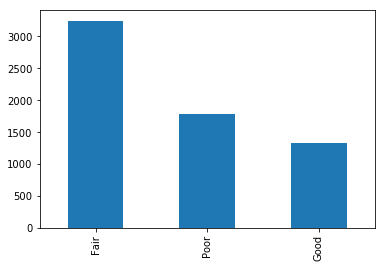

In [25]:
#basic bar graph to see distribution of accidents (just graphic representation of the dictionnaries)
PB_DF['oci_desc'].value_counts().plot(kind='bar')
print('PB MVA/OCI DISTRIBUTION')
plt.show()

GASLAMP MVA/OCI DISTRIBUTION


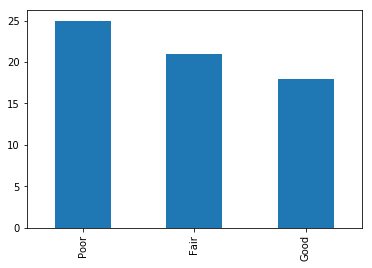

In [26]:
#Same for Gaslamp
GS_DF['oci_desc'].value_counts().plot(kind='bar')
print('GASLAMP MVA/OCI DISTRIBUTION')
plt.show()

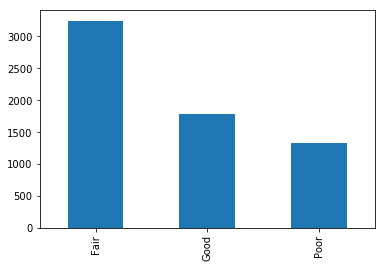

In [27]:
#This is for all SD - Can see the distribution is very different for GS and PB
Final_LL['oci_desc'].value_counts().plot(kind='bar')
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'set_color'

ALL SD


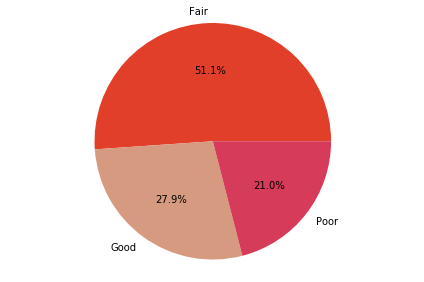

In [43]:
#Other way of representing the data but needs to be modified to match the colors so it is not hard coded like it is now

colors = ["#E13F29", "#D69A80", "#D63B59"]

# Create a pie chart
plt.pie(
    # using data total)arrests
    Final_LL['oci_desc'].value_counts(),
    labels=['Fair','Good','Poor'],
    shadow=False,
    colors=colors,
    autopct='%1.1f%%',
    )

# View the plot drop above
plt.axis('equal')
print('ALL SD')
# View the plot
plt.tight_layout()
plt.show()

PACIFIC BEACH


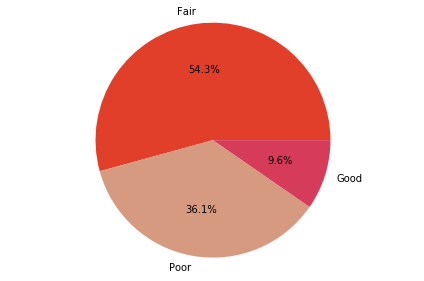

In [44]:
#Same here for PB
plt.pie(
    PB_DF['oci_desc'].value_counts(),
    labels=['Fair','Poor','Good'],
    shadow=False,
    colors=colors,
    autopct='%1.1f%%',
    )

# View the plot drop above
plt.axis('equal')
print('PACIFIC BEACH')
# View the plot
plt.tight_layout()
plt.show()

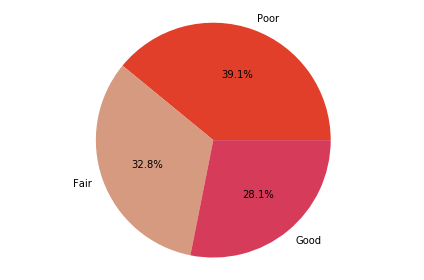

In [40]:
#Same for Gaslamp
plt.pie(
    GS_DF['oci_desc'].value_counts(),
    labels=['Poor','Fair','Good'],
    shadow=False,
    colors=colors,
    autopct='%1.1f%%',
    )

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.show()

In [23]:
print('PB DATA')
dic_size_PB
PB_DF['oci_desc'].value_counts()

PB DATA


Fair    248
Poor    165
Good     44
Name: oci_desc, dtype: int64

In [36]:
from scipy import stats
#Stats testing for OCI/MVA of PB vs Gaslamp ; PB vs All SD and Gaslamp vs all SD (only the 2 last are significant !!) 
s,p_PBVSGS = stats.ttest_ind(PB_DF['oci'],GS_DF['oci'])
s1,p_PBVSTOT = stats.ttest_ind(PB_DF['oci'],Final_LL['oci'])
s2,p_GSVSTOT = stats.ttest_ind(Final_LL['oci'],GS_DF['oci'])
#Respective p values
p_PBVSGS,p_PBVSTOT,p_GSVSTOT

(0.10667217498573706, 3.6611290407826837e-28, 0.0043552030525770028)

In [24]:
#This was for the testing on the OCI description but we have it for the continuous so not really useful just dont wanna delete it
stats.ttest_ind(PB_DF['oci_desc'].value_counts(),GS_DF['oci_desc'].value_counts())

Ttest_indResult(statistic=2.2104479985555541, pvalue=0.091580425106569649)

In [25]:
Final_LL['oci_desc'].value_counts()

Fair    3249
Good    1776
Poor    1334
Name: oci_desc, dtype: int64

In [26]:
#Same as above
stats.ttest_ind(PB_DF['oci_desc'].value_counts(),Final_LL['oci_desc'].value_counts())

Ttest_indResult(statistic=-3.3807325703336999, pvalue=0.027766646860717659)

In [28]:
#Same as above
stats.ttest_ind(GS_DF['oci_desc'].value_counts(),Final_LL['oci_desc'].value_counts())

Ttest_indResult(statistic=-3.6246489785355194, pvalue=0.022265210780188553)

In [55]:

OCI_DF = OCI([2011])
#
OCI_DF = OCI_DF[2011]
OCI_DF['oci']=(pd.to_numeric(OCI_DF['oci'],downcast='float'))

In [62]:
#T-TEST for the OCI of the MVA DF and The OCI of the OCI DF

print("Whole MVA Dataset's OCI compared to the oci's of the OCI Dataset of San Diego : ")
stats.ttest_ind(Final_LL['oci'],OCI_DF['oci'])

Whole MVA Dataset's OCI compared to the oci's of the OCI Dataset of San Diego : 


Ttest_indResult(statistic=1.4113302698230334, pvalue=0.15815628267723866)

In [63]:
print("Gaslamp's OCI compared to the oci's of the OCI Dataset of San Diego : ")
stats.ttest_ind(GS_DF['oci'],OCI_DF['oci'])

Gaslamp's OCI compared to the oci's of the OCI Dataset of San Diego : 


Ttest_indResult(statistic=-2.6041546990582169, pvalue=0.0092149527631916195)

In [64]:
print("PB's OCI compared to the oci's of the OCI Dataset of San Diego : ")
stats.ttest_ind(PB_DF['oci'],OCI_DF['oci'])

PB's OCI compared to the oci's of the OCI Dataset of San Diego : 


Ttest_indResult(statistic=-10.417831897715004, pvalue=2.2829231642576382e-25)

370765.75